#### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6

#### Carregar Dados

In [6]:
dados = pd.read_csv('airline.csv')

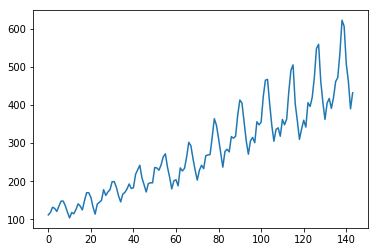

In [7]:
plt.plot(dados)
plt.show()

#### Pré-processamento

In [8]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [9]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [10]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):  #começa do 1 
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [11]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

In [12]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [13]:
serie = dados.values
serie_normalizada = normalizar_serie(serie)

In [14]:
janelas = gerar_janelas(20, serie_normalizada)

In [15]:
lags_acf = select_lag_acf(serie_normalizada, 20)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [16]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(janelas, 0.50, perc_val = 0.25)

Particao de Treinamento: 0 61
Particao de Validacao: 61 91
Particao de Teste: 91 123


#### Treinamento e Avaliação

In [19]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
    
    
    neuronios =  [1, 10]    #[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200]
    func_activation =  ['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs', 'sgd', 'adam']
    max_iteracoes = [100, 1000, 10000]
    learning_rate = ['constant', 'invscaling', 'adaptive']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variando a qtd de pontos utilizados na janela 
                            
                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])


                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                                
                                
                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    print('Melhor MSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag
    
    return select_model, qtd_lags_sel

In [20]:
exec_modelo = 1 # quantidade de vezes que cada configuração será executada 
modelo, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, exec_modelo)

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.004968482163730309
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.004808643762292132
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.004369513927025754
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.004357023301310174
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.003964906814759963
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.003584398325046852
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.003534035838884163
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0032158820820870535
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0019791412076662104
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0006540676648563369
QTD de Lags: 13 Qtd de Neuro

QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Fu

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Fu

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Fu

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Fu

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Fu

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lag

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de La

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de La

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lag

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lag

QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lag

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lag

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de La

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de La

QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 19 Qtd

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 19 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd

QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func

QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func.

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func.

/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu


/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/CIN/jvcm/tsenv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func.

#### Teste

In [ ]:
predict_test = modelo.predict(x_test[:, -lag_sel:])

In [ ]:
plt.plot(predict_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()

In [ ]:
MSE(y_test, predict_test)

### Diferentes metodologias 

> 1º Normalização +sem ACF + gridsearch 

> 2º Sem normalização + sem ACF + gridsearch

> 3º Normalização + ACF + gridsearch

#### 1º Normalização +sem ACF + gridsearch


In [15]:
dados.head()

,0
0,5.0
1,11.0
2,16.0
3,23.0
4,36.0


In [16]:
serie = dados.values

In [17]:
serie_normalizada = normalizar_serie(serie)

In [18]:
tam_janela = 20
serie_janelas = gerar_janelas(tam_janela, serie_normalizada)

In [19]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.70, perc_val = 0.15)

Particao de Treinamento: 0 205
Particao de Validacao: 205 248
Particao de Teste: 248 293


In [21]:
exec_modelo = 1
modelo, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, exec_modelo)


QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0267136369995
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0118849168015
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0114766096139
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0104420328427
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.00933975233588
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.00871538309946
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0086826936062
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
Q

QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identi

QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Fu

QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Fu

QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lag

QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lag

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lag

QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de La

QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de La

QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
QTD de La

QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd

QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 6 Qtd

QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd

QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func.

QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func.

QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func

QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
Melhor MSE: 0.00611014967901
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags

QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func.

QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func

In [22]:
predict_train = modelo.predict(x_train[:, -lag_sel:])
predict_val = modelo.predict(x_val[:, -lag_sel:])
predict_test = modelo.predict(x_test[:, -lag_sel:])

In [23]:
previsoes_train = np.hstack(( predict_train, predict_val))
target_train = np.hstack((y_train, y_val))

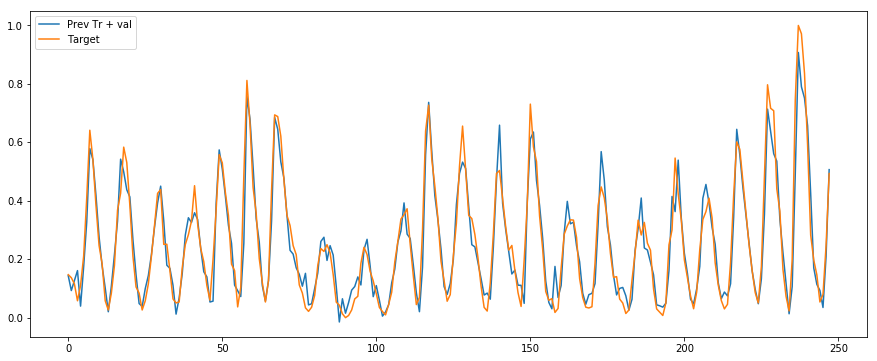

In [24]:
plt.plot(previsoes_train, label = 'Prev Tr + val')
plt.plot(target_train, label='Target')
plt.legend(loc='best')
plt.show()

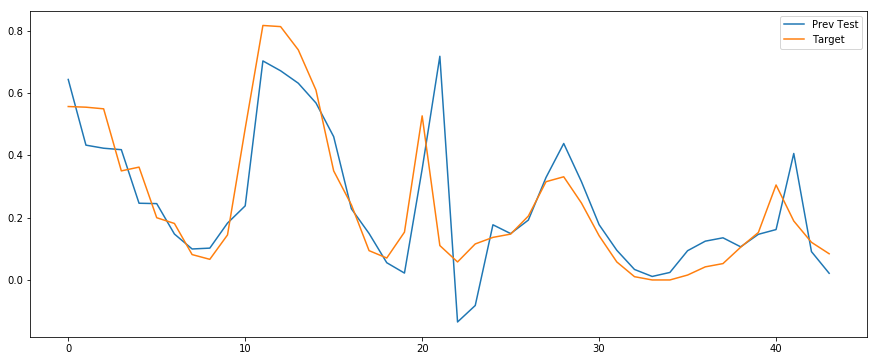

In [25]:
plt.plot(predict_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()

In [27]:
# desnormaliza para calcular o MSE
predict_test_real = desnormalizar(predict_test, serie)
target_real = desnormalizar(y_test, serie)

In [28]:
MSE(target_real, predict_test_real)

651.327727282095

#### Sem normalização + sem ACF + gridsearch

In [29]:
serie_janelas = gerar_janelas(20, serie)

In [30]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.70, perc_val = 0.15)

Particao de Treinamento: 0 205
Particao de Validacao: 205 248
Particao de Teste: 248 293


In [31]:
modelo, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, exec_modelo)

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 966.46149555
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 429.412728168
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 409.217549136
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 377.77840917
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 327.203521458
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 312.573684123
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 307.909876915
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd

QTD de Lags: 18 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 17 Qtd de Neuronios 1 Fu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_base.py:194: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [32]:
predict_train = modelo.predict(x_train[:, -lag_sel:])
predict_val = modelo.predict(x_val[:, -lag_sel:])
predict_test = modelo.predict(x_test[:, -lag_sel:])

In [33]:
previsoes_train = np.hstack(( predict_train, predict_val))
target_train = np.hstack((y_train, y_val))

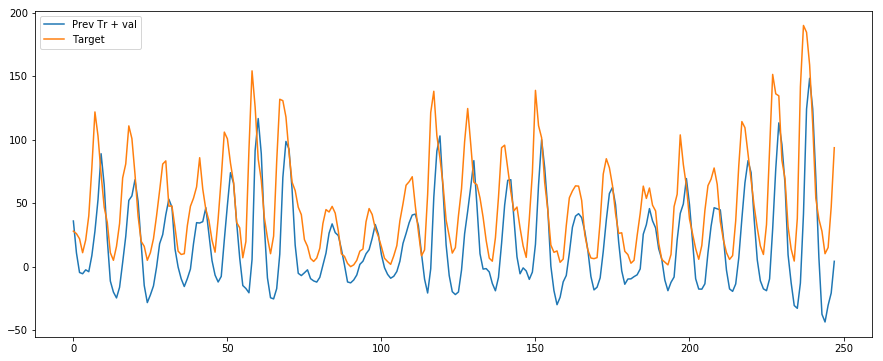

In [34]:
plt.plot(previsoes_train, label = 'Prev Tr + val')
plt.plot(target_train, label='Target')
plt.legend(loc='best')
plt.show()

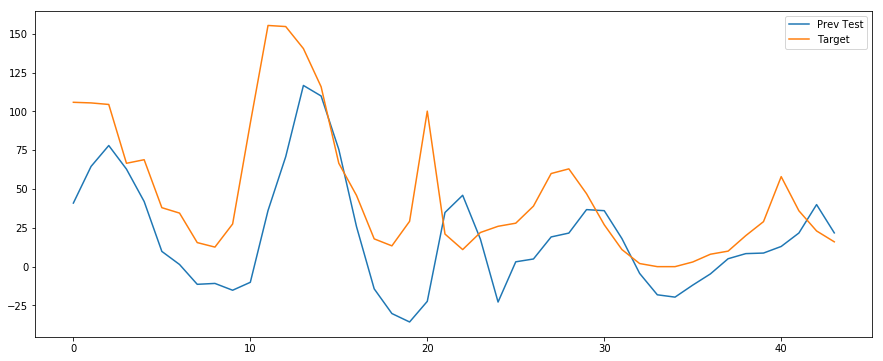

In [35]:
plt.plot(predict_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()

In [36]:
MSE(y_test, predict_test)

1836.4218241576718

#### Normalização + ACF + gridsearch

In [37]:
serie_normalizada = normalizar_serie(serie)

In [38]:
serie_janelas = gerar_janelas(20, serie_normalizada)

In [39]:
lags_acf = select_lag_acf(serie_normalizada, 20)

LAGS [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16]


In [40]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.70, perc_val = 0.15)

Particao de Treinamento: 0 205
Particao de Validacao: 205 248
Particao de Teste: 248 293


In [41]:
x_train_acf =  x_train[:, lags_acf]
x_test_acf = x_test[:, lags_acf]
x_val_acf = x_val[:, lags_acf]

In [42]:
modelo, lag_sel = treinar_mlp(x_train_acf, y_train, x_val_acf, y_val, exec_modelo)

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0790707329335
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0725584516446
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.061296789328
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.040618270379
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.035771870154
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0351442091777
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
Melhor MSE: 0.0242641114659
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act 

QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de 

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd

QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd

QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd

QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act identity
QTD de Lags: 5 Qtd de Neur

QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tan

QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tan

QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act rel

QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act rel

In [43]:
predict_train = modelo.predict(x_train_acf[:, -lag_sel:])
predict_val = modelo.predict(x_val_acf[:, -lag_sel:])
predict_test = modelo.predict(x_test_acf[:, -lag_sel:])

In [44]:
previsoes_train = np.hstack(( predict_train, predict_val))
target_train = np.hstack((y_train, y_val))

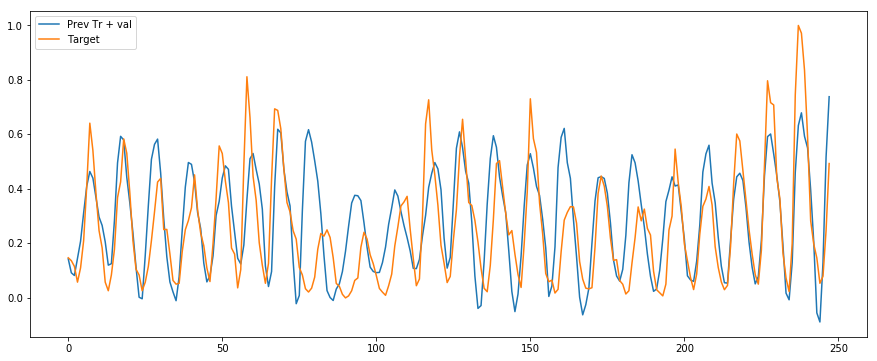

In [45]:
plt.plot(previsoes_train, label = 'Prev Tr + val')
plt.plot(target_train, label='Target')
plt.legend(loc='best')
plt.show()

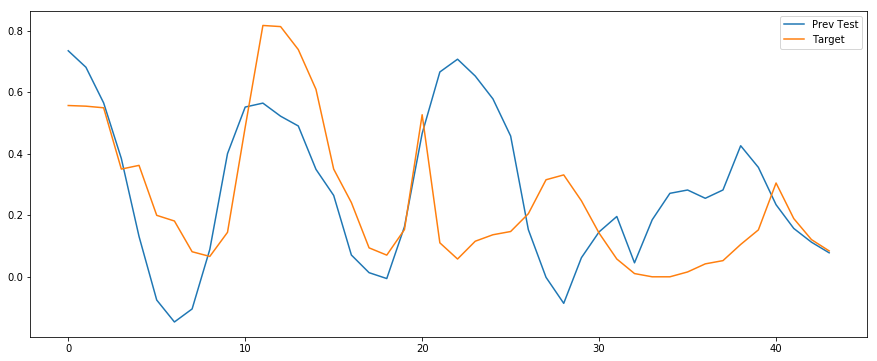

In [46]:
plt.plot(predict_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()

In [47]:
# desnormaliza para calcular o MSE
predict_test_real = desnormalizar(predict_test, serie)
target_real = desnormalizar(y_test, serie)

In [48]:
MSE(target_real, predict_test_real)

2294.7911067680416